In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import load_dataset
import nltk
import re
from nltk.corpus import stopwords
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import warnings
warnings.filterwarnings('ignore')
import joblib
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:
#Load data
df = load_dataset("stanfordnlp/imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
#Load train and test data
train_data = df["train"]
test_data = df["test"]

In [ ]:
#create data frame of train and test set
train_df = pd.DataFrame(df["train"])
test_df = pd.DataFrame(df["test"])

In [ ]:
#take 80% data from testset for testing
test_df , _= train_test_split(test_df, test_size=0.8, random_state=42,)

In [ ]:
# test_df.to_csv('test.csv')

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#preprocessing data

happy_emojis = [':-D', ':)', ':P', ';)', ';-)']
sad_emojis = [':(', ';(', ':—',':-(']

#define expanding contraction
dict = {
    'don\'t': 'do not',
    'didn\'t': 'did not',
    'thx': 'thanks',
    'thnx': 'thanks',
    'shouldn\'t': 'should not',
    'wouldn\'t': 'would not',
    'couldn\'t': 'could not',
    'haven\'t': 'have not',
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "isn't" : "is not"

}

#define pre-process function
def preprocess(text):
    text = text.lower() #lowercase the rext
    text = re.sub('<br />', '', text) #remove hyperlink
    text = re.sub(r'http\S+', '', text) #remove webaddress
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

    # Replace emotion patterns
    for emoji in happy_emojis:
        text = text.replace(emoji, 'happy')
    for emoji in sad_emojis:
        text = text.replace(emoji, 'sad')


    puntuation_pattern = re.compile(r'\b(' + '|'.join(dict.keys()) + r')\b')
    text = puntuation_pattern.sub(lambda x: dict[x.group(0)], text) #replace short forms with full forms

    text = text.replace('?', ' questionmark') #define ? and ! to a word which could define emotions of positive and
    text = text.replace('!', ' exclamatorymark')

    text = re.sub('[^a-zA-Z]', ' ', text) #remove non alphabatical character

    tokens = re.findall(r'\b\w+\b', text) # text to tokens, split on space


    # lemitization and remove stop words
    lemmatize = WordNetLemmatizer()
    stopWords = set(stopwords.words('english'))
    stopWords = set(stopWords)
    stopWords.discard('not') # not including not in stop word
    stopWords.discard('but') #not including but in stop word

    text_lemma = [lemmatize.lemmatize(word) for word in tokens if word not in stopWords]


    text = ' '.join(text_lemma) #convert to original text by joining with space

    return text

In [ ]:
x_final = [preprocess(text) for text in train_df['text']] #pre-process text/reviews

In [ ]:
x_final[:3] #checking first three pre-processed text

['rented curious yellow video store controversy surrounded first released also heard first seized u custom ever tried enter country therefore fan film considered controversial really see plot centered around young swedish drama student named lena want learn everything life particular want focus attention making sort documentary average swede thought certain political issue vietnam war race issue united state asking politician ordinary denizen stockholm opinion politics sex drama teacher classmate married men kill curious yellow year ago considered pornographic really sex nudity scene far even not shot like cheaply made porno countryman mind find shocking reality sex nudity major staple swedish cinema even ingmar bergman arguably answer good old boy john ford sex scene film commend filmmaker fact sex shown film shown artistic purpose rather shock people make money shown pornographic theater america curious yellow good film anyone wanting study meat potato pun intended swedish cinema but

In [ ]:
#create baseline model with the help of pipeline ( defined feature extraction usig 3-grams and then modelling using Logistic regression)
baseModel_pipeline = Pipeline([

        ('vect', CountVectorizer(ngram_range=(1,3))),
        # ('vect', TfidfVectorizer(ngram_range=(1, 3))),
        # ('select', SelectKBest(chi2, k=1100)),
        # ('scaler', StandardScaler(with_mean=False)),

        ('clf',  LogisticRegression()),


    ])
baseModel_pipeline.fit(x_final, train_df['label'])


Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 3))),
                ('clf', LogisticRegression())])

In [ ]:
x_test = [preprocess(text) for text in test_df['text']] #pre-process test text data

In [ ]:
y_pred = baseModel_pipeline.predict(x_test) #predict labels(setimenents 0-negative and 1 -positive)


In [ ]:
#Best baseline model performance
print('Baseline Model Performance:')
print('Accuracy: ', accuracy_score(test_df['label'], y_pred))
print('Precision: ', precision_score(test_df['label'], y_pred))
print('F1_score: ', f1_score(test_df['label'], y_pred))

Baseline Model Performance:
Accuracy:  0.9016
Precision:  0.9095276220976781
F1_score:  0.9023034154090549


In [ ]:
#Best baseline model performance
print('Baseline Model Performance:')
print('Accuracy: ', accuracy_score(test_df['label'], y_pred))
print('Precision: ', precision_score(test_df['label'], y_pred))
print('F1_score: ', f1_score(test_df['label'], y_pred))

Baseline Model Performance:
Accuracy:  0.9016
Precision:  0.9095276220976781
F1_score:  0.9023034154090549


<Axes: >

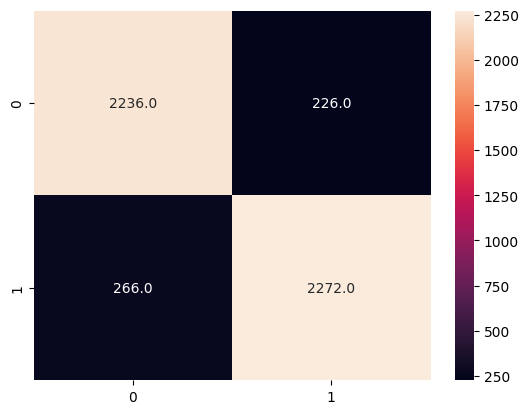

In [ ]:
#confusion matric to understand predictions and ground truths
sns.heatmap(confusion_matrix(test_df['label'],y_pred), annot=True, fmt= '.1f')

In [ ]:
#mount drive which we will use to save best model in drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Save best model
# joblib.dump(baseModel_pipeline, '/content/drive/NLP_Coursework/Baseline_best_model')

['/content/drive/MyDrive/My_NLP/Coursework/Baseline_best_model']

In [ ]:
#perform error analysis by aalysing coeficient, which defines the weights assigned to the each feature
model_learned = baseModel_pipeline.named_steps['clf']

In [ ]:
model_vectorizer = baseModel_pipeline.named_steps['vect']
feature_names = model_vectorizer.get_feature_names_out()

In [ ]:
model_coefficients = model_learned.coef_[0]

In [ ]:
coefficient_df = pd.DataFrame({'Words': feature_names, 'Coefficient': model_coefficients})

In [ ]:
coefficient_df['absolute_coeficient'] = abs(coefficient_df['Coefficient'])
coefficient_df = coefficient_df.sort_values(by='absolute_coeficient', ascending=False)

In [ ]:
top_10_positive_features = coefficient_df.head(10) #highest coeficients are responsible for positive class -1 and lowest for negative class 0
top_10_negative_features = coefficient_df.tail(10)

In [ ]:
top_10_positive_features

,Words,Coefficient,absolute_coeficient
4487508,worst,-1.975659,1.975659
271486,awful,-1.590610,1.590610
4343789,waste,-1.496545,1.496545
435131,boring,-1.439496,1.439496
1275517,excellent,1.392666,1.392666
4002473,terrible,-1.183168,1.183168
4485251,worse,-1.163514,1.163514
1029077,disappointment,-1.161027,1.161027
3082577,poorly,-1.156548,1.156548
3079938,poor,-1.139131,1.139131


In [ ]:
top_10_negative_features

,Feature name,Coefficient,absulute_coeficient
3841894,store make,9.564120e-08,9.564120e-08
4262679,usually keep,8.412939e-08,8.412939e-08
2849476,one day looking,-6.962251e-08,6.962251e-08
1451444,film moved along,-5.907977e-08,5.907977e-08
402578,black woman named,5.121118e-08,5.121118e-08
4542696,young black woman,5.121118e-08,5.121118e-08
1145731,eleven episode,-3.680442e-08,3.680442e-08
1529209,following short,2.622253e-08,2.622253e-08
2832822,ok but one,1.390632e-08,1.390632e-08
1896455,horse movie not,-6.694231e-09,6.694231e-09


In [ ]:
#Experimenting with random text
# text = "After reading the book, I loved the story. Watching the movie I was disappointed that so many changes were made. It is understandable that books and movies differ but it was two different stories, only the names and some of the book's story remained. Read the book and you'll have a better understanding of the movie. The book gives you a better development of the characters. These characters are extremely interesting and make you care about them. The locations were indeed in line with the book's descriptions. Some characters not included. Television has microwaved so many great books and stories, this is a perfect example of that. Input from the author doesn't always insure a good movie but it can help sometimes."
# x_test_example = preprocess(text)

In [ ]:
# y_pred_example = baseModel_pipeline.predict([x_test_example])
# y_pred_example

array([0])

In [ ]:
#creating a testing df which will have text, predicted label and true label
testing_df = pd.DataFrame(test_df['text'])

In [ ]:
testing_df.head()

,text
23703,ý thýnk uzak ýs the one of the best films of a...
1717,This movie started out as a quite decent-looki...
2696,"As was mentioned before in other comments, the..."
1848,Ghoulies IV starts in a museum storage facilit...
10623,I watched this as part of a vampire movie mara...


In [ ]:
testing_df['label'] =test_df['label']
testing_df['predicted_label'] = y_pred
testing_df['cleaned_text'] =x_test

In [ ]:
testing_df.head()

,text,label,predicted_label,cleaned_text
23703,ý thýnk uzak ýs the one of the best films of a...,1,1,th nk uzak one best film time everybody must r...
1717,This movie started out as a quite decent-looki...,0,0,movie started quite decent looking film but ne...
2696,"As was mentioned before in other comments, the...",0,0,mentioned comment major problem nva cannot dec...
1848,Ghoulies IV starts in a museum storage facilit...,0,0,ghoulies iv start museum storage facility pvc ...
10623,I watched this as part of a vampire movie mara...,0,0,watched part vampire movie marathon research i...


In [ ]:
#for error analysis we have fileted where classes are misclassified
error_analysis = testing_df[testing_df['label']!=testing_df['predicted_label']]
error_analysis.head()

,text,label,predicted_label,cleaned_text
1756,If you are a Catalan nationalist anarcho-socia...,0,1,catalan nationalist anarcho socialist unnuance...
19741,One of the more interesting films I've seen. L...,1,0,one interesting film seen lord montague isblac...
9104,It's just a bad film.Not as bad as R.I.C.C.O. ...,0,1,bad film not bad r c c but bad got hooked begi...
721,If this movie were in production today it woul...,0,1,movie production today would probably christia...
17270,'Wicked Little Things' really separates itself...,1,0,wicked little thing really separate zombie mov...


In [ ]:
# !python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# import spacy
# nlp = spacy.load("en_core_web_lg")

In [ ]:
# x_test1 = [nlp(x).vector for x in x_test ]

In [ ]:
# y_pred1 = baseModel_pipeline.predict(x_test1)

In [ ]:
# print('Baseline Model Performance:')
# print('Accuracy: ', accuracy_score(test_data['label'], y_pred1))

Baseline Model Performance:
Accuracy:  0.83476
